# Try out the PhytoClassUCSC model for yourself

Using this notebook, you should able to clone the model repo off of Hugging Face, grab an image from the Santa Cruz Wharf IFCB dataset on the CalOOS Dashboard instance, and run it through the classifier.


In [1]:

!GIT_LFS_SKIP_SMUDGE=1 
!git clone https://huggingface.co/patcdaniel/phytoClassUCSC
!pip install keras_preprocessing

Cloning into 'phytoClassUCSC'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 41 (delta 3), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (41/41), 11.89 KiB | 1014.00 KiB/s, done.
Filtering content: 100% (13/13), 170.46 MiB | 35.50 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 989.5 kB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras_preprocessing.image as keras_img
import numpy as np
import json, os
import matplotlib.pyplot as plt
import urllib.request

Load the Model (phytoClassUCSC.h5)

In [3]:
model  = tf.keras.saving.load_model("./phytoClassUCSC/phytoClassUCSC.h5")
with open("./phytoClassUCSC/class_list.json") as json_file:
  class_list = list(json.load(json_file))

Grab an image from the CalOOS Dashboard.

Let's download some images off of the CalOOS IFCB Dashboard ([ifcb.caloos.org](ifcb.caloos.org))

In [42]:
# Add any more images here if you want
fnames = [
    "https://ifcb.caloos.org/data/D20230720T093400_IFCB104_02924.png",
    "https://ifcb.caloos.org/data/D20220614T171551_IFCB161_00474.png",
    "https://ifcb.caloos.org/data/D20220614T171551_IFCB161_00060.png",
    "https://ifcb.caloos.org/data/D20220614T171551_IFCB161_00292.png"
    ]

for fname in fnames:
  save_name = fname.split("/")[-1]
  urllib.request.urlretrieve(fname, filename=os.path.join("/content",save_name))

The images need to be reshaped into a certain size and format for the model, so the code below loads the image, resizes it, changes it to a three channel R,G,B and returns the image as an array.

In [43]:
def prep_image(fname):
    """Load and prep images for model, reshape and normalize rgb to greyscale"""
    target_size=(224,224)
    img = keras_img.img_to_array(
            keras_img.load_img(fname, target_size=target_size)
    )
    img /= 255
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    return img


In [44]:
fname = fnames[0].split("/")[-1] # Get the first image
img = prep_image(fname)

Use the model to predict the class

In [45]:
yhat = model.predict(img)

1/1 [==============================] - 0s 256ms/step


In [46]:
top_ix = np.argmax(yhat)
top_guess_conf = yhat[0,top_ix]
top_guess = class_list[top_ix]

print("The model predited {} with {} confidence!".format(top_guess, round(top_guess_conf, 4)))

The model predited Eucampia with 0.9995999932289124 confidence!


Now lets put all of the images into an array.

There are many ways to do this, but here we are going to load each image individually, preproccess it, and then add it to a pre-defined array.

Arrays need to be stacked along the first dimension.

In [65]:
imgs = np.empty(shape=(len(fnames),224,224,3))
for i, fname in enumerate(fnames):
  fname = fname.split("/")[-1] # get the file name from the URL
  imgs[i,:,:,:] = prep_image(fname)

# This is the same as before, but now the prediction has an extra dimension for each image
yhat = model.predict(imgs)
top_ix = np.argmax(yhat,axis=1) # get the top class for each image

1/1 [==============================] - 1s 1s/step


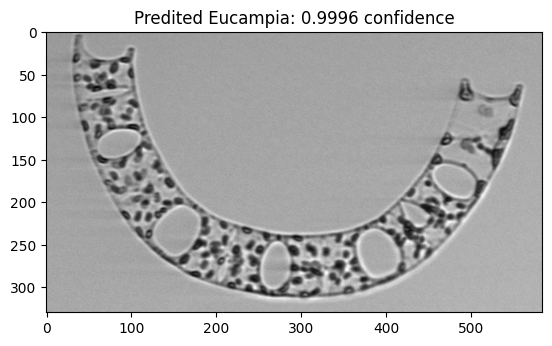

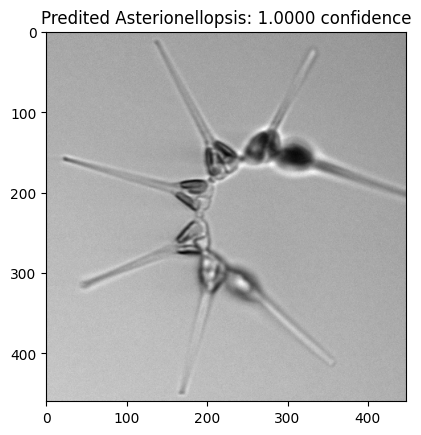

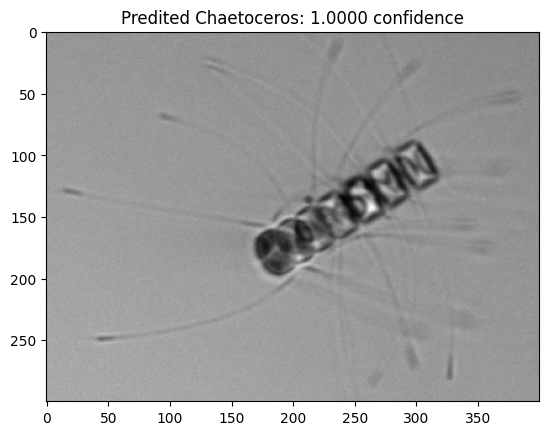

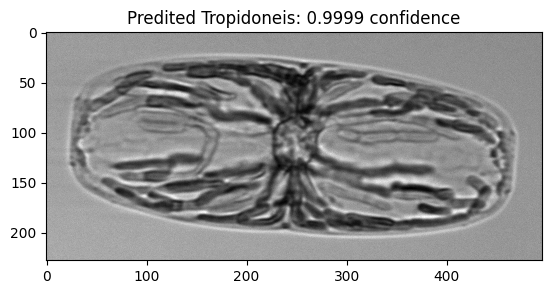

In [88]:
for i, fname in enumerate(fnames):
  plt.figure()
  fname = fname.split("/")[-1]
  im = plt.imread(fname)
  ax = plt.imshow(im, cmap='gray')

  top_guess_conf = yhat[i,top_ix[i]]
  top_guess = class_list[top_ix[i]]
  plt.title("Predited {}: {:6.4f} confidence".format(top_guess, top_guess_conf))